Importing Packages and Libraries

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz # used for Fuzzy K Means Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

# Suppress warnings (Local Machine CAN be removed later)
import warnings
warnings.filterwarnings('ignore')
import os 
os.environ['OMP_NUM_THREADS'] = '1'

Load 'Mall_Customers.CSV' Dataset

In [196]:
df = pd.read_csv('Mall_Customers.csv')

Initial View on the 'Mall_Customers.csv" Data

What Features are most suited to be clustered?

In [197]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("Dataset info:")
print(df.info())

Dataset shape: (200, 5)

First few rows:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
N

Annual Income (k$) and Spending Score (1-100) Chosen Features

Chosen For: Business Monetary Insight

StandardScaler Class Used to ensure that data is standardized (So Ranges WON'T skew data points)

In [198]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Finding Optimal_K (Clusters)

2 Methods
    
    Fuzzy Partition Coefficient
    
    Fuzzy Silhouette Score

Defines Sihlouette Function

Tests via Loop: membership matrix to determine optimal cluster number from a range of 2 to 10 Clusters

Applied Fuzziness = 2 ( as standard practice for fuzzy clustering )

np.random.seed(42) to give reproducable results

In [199]:
# Define Fuzzy Sihlhouette Score Function
def fuzzy_silhouette(X, u):
    from sklearn.metrics import pairwise_distances
    n_samples = X.shape[0]
    n_clusters = u.shape[0]
    dists = pairwise_distances(X)
    sil_scores = []
    for i in range(n_samples):
        a = 0
        b = np.inf
        for k in range(n_clusters):
            weights = u[k]
            a_k = np.sum(weights * dists[i]) / np.sum(weights)
            if u[k, i] == np.max(u[:, i]):
                a = a_k
            else:
                b = min(b, a_k)
        sil = (b - a) / max(a, b)
        sil_scores.append(sil)
    return np.mean(sil_scores)

In [200]:
K = range(2, 11)
fpcs = [] # Fuzzy Partition Coefficient
silhouette_scores = [] # Silhouette Scores

# Loop through different cluster sizes
np.random.seed(42)
for k in K:
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_scaled.T, k, 2, error=0.005, maxiter=1000, init=None
    )
    fpcs.append(fpc)
    score = fuzzy_silhouette(X_scaled, u)
    silhouette_scores.append(score)

Plotted Results of
    
    Fuzzy Silhouette V Optimal K

    FPC V Optimal K

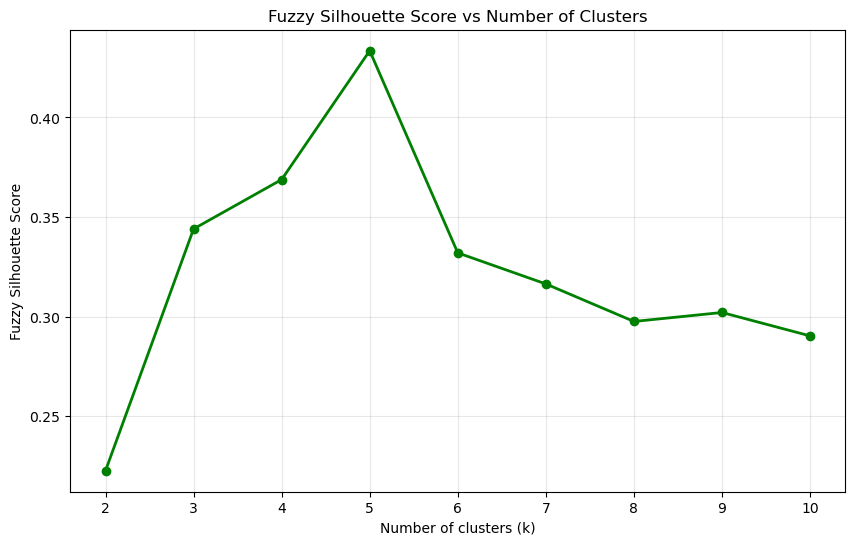

Optimal number of clusters by fuzzy silhouette: 5


In [201]:
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'go-', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Fuzzy Silhouette Score')
plt.title('Fuzzy Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal k by silhouette
optimal_k_sil = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters by fuzzy silhouette: {optimal_k_sil}")

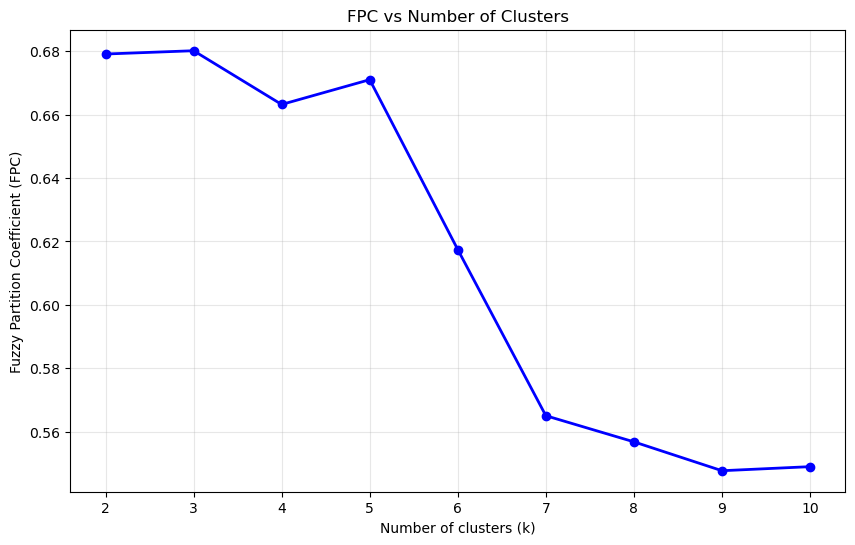

Optimal number of clusters: 3


In [202]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(K, fpcs, 'bo-', linewidth=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.title('FPC vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal k
optimal_k = K[fpcs.index(max(fpcs))]
print(f"Optimal number of clusters: {optimal_k}")

Cluster using Optimal K

In [203]:
# FPC-optimal clustering
cntr_fpc, u_fpc, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_scaled.T, optimal_k, 2, error=0.005, maxiter=1000, init=None
)
hard_labels_fpc = np.argmax(u_fpc, axis=0)

# Silhouette-optimal clustering
cntr_sil, u_sil, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_scaled.T, optimal_k_sil, 2, error=0.005, maxiter=1000, init=None
)
hard_labels_sil = np.argmax(u_sil, axis=0)

In [204]:
def run_fuzzy_cmeans_and_report(k, X_scaled, scaler, cntr, u, hard_labels):
    sil_score = fuzzy_silhouette(X_scaled, u)
    cntr_original = scaler.inverse_transform(cntr)
    print(f"\nResults for k={k}:")
    print(f"  FPC: {np.mean(u ** 2):.3f}")
    print(f"  Fuzzy Silhouette Score: {sil_score:.3f}")
    print("  Cluster Centers (Original Scale):")
    print("  Cluster | Annual Income | Spending Score")
    print("  " + "-" * 40)
    for i in range(k):
        print(f"  {i:7d} | {cntr_original[i,0]:12.1f} | {cntr_original[i,1]:13.1f}")
    print("  Cluster Profiles:")
    for i in range(k):
        members = X[hard_labels == i]
        print(f"    Cluster {i}: Count={len(members)}, Mean Income={members[:,0].mean():.2f}, Mean Spending={members[:,1].mean():.2f}")
    print()

run_fuzzy_cmeans_and_report(optimal_k, X_scaled, scaler, cntr_fpc, u_fpc, hard_labels_fpc)
run_fuzzy_cmeans_and_report(optimal_k_sil, X_scaled, scaler, cntr_sil, u_sil, hard_labels_sil)


Results for k=3:
  FPC: 0.227
  Fuzzy Silhouette Score: 0.344
  Cluster Centers (Original Scale):
  Cluster | Annual Income | Spending Score
  ----------------------------------------
        0 |         79.3 |          80.3
        1 |         79.9 |          19.1
        2 |         46.3 |          50.2
  Cluster Profiles:
    Cluster 0: Count=40, Mean Income=85.33, Mean Spending=82.38
    Cluster 1: Count=38, Mean Income=87.00, Mean Spending=18.63
    Cluster 2: Count=122, Mean Income=44.20, Mean Spending=49.48


Results for k=5:
  FPC: 0.134
  Fuzzy Silhouette Score: 0.433
  Cluster Centers (Original Scale):
  Cluster | Annual Income | Spending Score
  ----------------------------------------
        0 |         86.1 |          16.7
        1 |         27.1 |          18.5
        2 |         84.4 |          82.8
        3 |         26.5 |          77.9
        4 |         56.2 |          49.6
  Cluster Profiles:
    Cluster 0: Count=35, Mean Income=88.20, Mean Spending=17.11
    

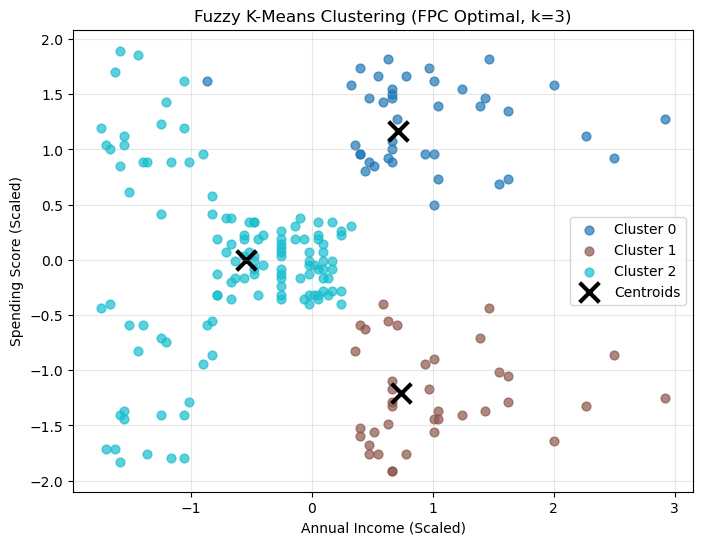

In [205]:
# FPC-optimal clustering plot
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_points = X_scaled[hard_labels_fpc == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[i], label=f'Cluster {i}', alpha=0.7, s=40)
plt.scatter(cntr_fpc[:, 0], cntr_fpc[:, 1], c='black', marker='x', s=200, linewidth=3, label='Centroids')
plt.xlabel('Annual Income (Scaled)')
plt.ylabel('Spending Score (Scaled)')
plt.title(f'Fuzzy K-Means Clustering (FPC Optimal, k={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

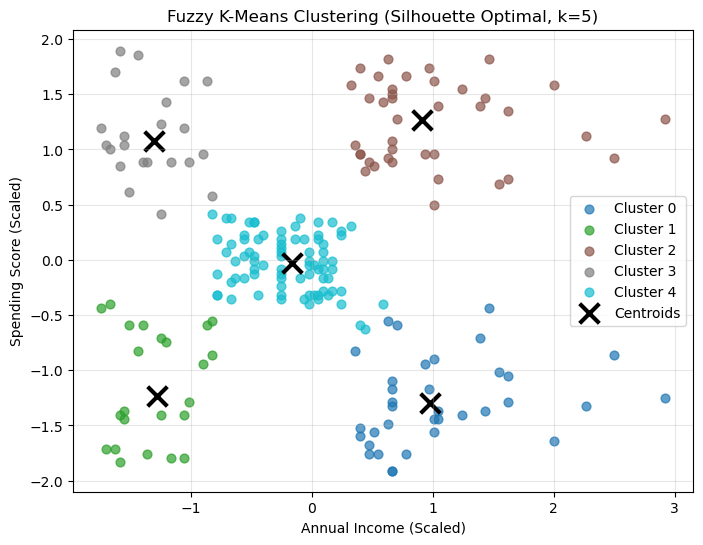

In [206]:
# Silhouette-optimal clustering plot
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k_sil))
for i in range(optimal_k_sil):
    cluster_points = X_scaled[hard_labels_sil == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[i], label=f'Cluster {i}', alpha=0.7, s=40)
plt.scatter(cntr_sil[:, 0], cntr_sil[:, 1], c='black', marker='x', s=200, linewidth=3, label='Centroids')
plt.xlabel('Annual Income (Scaled)')
plt.ylabel('Spending Score (Scaled)')
plt.title(f'Fuzzy K-Means Clustering (Silhouette Optimal, k={optimal_k_sil})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

First 10 Customer Check

Shows the degree of which cluster the customer belongs to

In [207]:
def show_memberships(df, u, hard_labels, method_name):
    k = u.shape[0]
    data = []
    for i in range(10):
        row = {
            "Income": df.iloc[i]['Annual Income (k$)'],
            "Spending Score": df.iloc[i]['Spending Score (1-100)'],
            "Assigned Cluster": hard_labels[i]
        }
        for c in range(k):
            row[f"Cluster {c} Membership"] = round(u[c, i], 3)
        data.append(row)
    display(pd.DataFrame(data))

print("FPC-optimal clustering (first 10 customers):")
show_memberships(df, u_fpc, hard_labels_fpc, "FPC")

print("Silhouette-optimal clustering (first 10 customers):")
show_memberships(df, u_sil, hard_labels_sil, "Silhouette")

FPC-optimal clustering (first 10 customers):


,Income,Spending Score,Assigned Cluster,Cluster 0 Membership,Cluster 1 Membership,Cluster 2 Membership
0,15,39,2,0.132,0.168,0.700
1,15,81,2,0.276,0.140,0.584
2,16,6,2,0.152,0.346,0.502
3,16,77,2,0.253,0.135,0.613
4,17,40,2,0.125,0.157,0.718
5,17,76,2,0.246,0.132,0.622
6,18,6,2,0.149,0.351,0.500
7,18,94,2,0.353,0.145,0.502
8,19,3,2,0.149,0.369,0.482
9,19,72,2,0.219,0.123,0.658


Silhouette-optimal clustering (first 10 customers):


,Income,Spending Score,Assigned Cluster,Cluster 0 Membership,Cluster 1 Membership,Cluster 2 Membership,Cluster 3 Membership,Cluster 4 Membership
0,15,39,1,0.056,0.541,0.046,0.185,0.173
1,15,81,3,0.013,0.030,0.026,0.885,0.046
2,16,6,1,0.047,0.823,0.022,0.043,0.065
3,16,77,3,0.011,0.027,0.021,0.899,0.041
4,17,40,1,0.056,0.521,0.047,0.191,0.184
5,17,76,3,0.010,0.024,0.018,0.910,0.038
6,18,6,1,0.043,0.839,0.020,0.038,0.060
7,18,94,3,0.025,0.045,0.059,0.794,0.077
8,19,3,1,0.054,0.809,0.023,0.043,0.070
9,19,72,3,0.011,0.027,0.019,0.900,0.043
